# TDL 14/12
- New index for transaction DONE
- Standardize the data DONE
- Check h and phi distribution, adjust the weight initialization if necessary SOSO
- Layernorm ? NO, BUT COMPLICATED
- Idem with the monotonic decoder, investigate its initialization

In [1]:
import numpy as np
import pandas as pd
import os
import math
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [2]:
os.chdir('../..')

In [3]:
# events
events = pd.read_csv("data/LOBSTER/AMZN_2012-06-21_34200000_57600000_events_5.csv")

In [4]:
# preprocess
messages = pd.read_csv('data/LOBSTER/AMZN_2012-06-21_34200000_57600000_message_5.csv',header=None)
orderbook = pd.read_csv('data/LOBSTER/AMZN_2012-06-21_34200000_57600000_orderbook_5.csv',header=None)

messages_columns = ["time","type","id","size","price","direction"]
messages.columns = messages_columns

orderbook_columns = []
for i in range(1,6):
    orderbook_columns.append("ask_price_" + str(i))
    orderbook_columns.append("ask_size_" + str(i))
    orderbook_columns.append("bid_price_" + str(i))
    orderbook_columns.append("bid_size_" + str(i))
orderbook.columns = orderbook_columns

# Feature engineering

- Avg. trades / min to be computed

In [5]:
# the orderbook snapshots correspond to snapshots AFTER events
orderbook["time"] = messages["time"]

# feature engineering
orderbook["midprice"] = (orderbook["ask_price_1"] + orderbook["bid_price_1"]) / 2
orderbook["spread"] = orderbook["ask_price_1"] - orderbook["bid_price_1"]
orderbook["midprice_returns"] = np.log(orderbook["midprice"]).diff()
orderbook["rolling_vol"] = (orderbook["midprice_returns"]**2).rolling(window=1000).mean()
orderbook["volume_imbalance"] = (orderbook["bid_size_1"] - orderbook["ask_size_1"]) / (orderbook["ask_size_1"] + orderbook["bid_size_1"])
orderbook["microprice"] = orderbook["midprice"]+(orderbook["volume_imbalance"]*orderbook["spread"])
# why mid_price in microprice?
seconds_per_day = 3600*24
orderbook['cos_time'] = np.cos(2*np.pi*orderbook['time']/seconds_per_day)
orderbook['sin_time'] = np.cos(2*np.pi*orderbook['time']/seconds_per_day)

In [6]:
messages['datetime'] = pd.to_datetime(messages['time'], unit='s')
orderbook['datetime'] = pd.to_datetime(orderbook['time'], unit='s')

messages.set_index('datetime', inplace=True) # bad index, not unique !
orderbook.set_index('datetime', inplace=True) # bad index, not unique !

orderbook["roll_avg_trades_per_min"] = messages["size"].rolling(window='5min').sum()/5
orderbook.drop(columns=["midprice_returns"], inplace=True)

messages.reset_index(inplace=True)
orderbook.reset_index(inplace=True)
messages.drop(columns=["datetime"], inplace=True)
orderbook.drop(columns=["datetime"], inplace=True)

<Axes: >

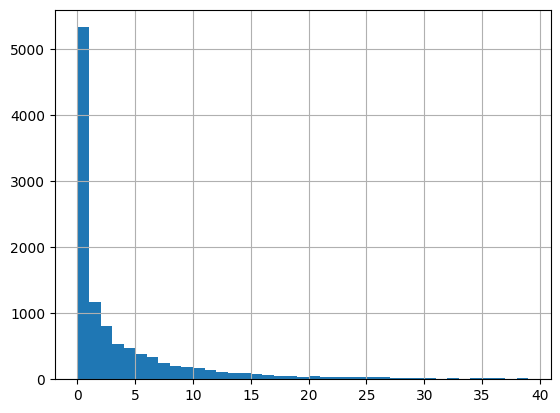

In [7]:
# about lifetimes
(events["lifetime"][events["level"]==0]).hist(bins=np.arange(0,40,1))

In [8]:
from sklearn.preprocessing import StandardScaler

# join and standardize
orderbook["id_message"] = messages["id"]
merged = orderbook.merge(events, how='left', left_on='id_message', right_on='id_sub')
merged.drop(columns=["id_sub","id_message","time","t_sub"], inplace=True)

# Standardize but exclude the last two columns
columns_to_standardize = merged.columns[:-3] # lifetime is also standardized
features = merged.columns[:-3]
scaler = StandardScaler()
merged[columns_to_standardize] = scaler.fit_transform(merged[columns_to_standardize])
merged["lifetime"] = merged["lifetime"] / 10 # scale down lifetime by hand (too much outliers to use sklearn)


In [9]:
# features
print("features:")
print(list(features))
print(len(features),"features")

features:
['ask_price_1', 'ask_size_1', 'bid_price_1', 'bid_size_1', 'ask_price_2', 'ask_size_2', 'bid_price_2', 'bid_size_2', 'ask_price_3', 'ask_size_3', 'bid_price_3', 'bid_size_3', 'ask_price_4', 'ask_size_4', 'bid_price_4', 'bid_size_4', 'ask_price_5', 'ask_size_5', 'bid_price_5', 'bid_size_5', 'midprice', 'spread', 'rolling_vol', 'volume_imbalance', 'microprice', 'cos_time', 'sin_time', 'roll_avg_trades_per_min']
28 features


- The volatility is estimated using a rolling mean of 1000 trades over the squared returns of the midprice timeseries.  
- 5-minute bucket average statistics for the trading volume.

# Datapoints from events

In [10]:
# key parameter
horizon = 100 # in number of trade, not ms

datapoints = {}
events_indexes = merged.index[merged["lifetime"].notna()]
with_nans = 0
N = 10000

for event_idx in tqdm(events_indexes[:N]):
    # extract
    row = merged.loc[event_idx]
    lifetime,level,cause = row["lifetime"],row["level"],int(row["cause"])
    subdf = merged.loc[:event_idx].iloc[-horizon:]
    X = subdf[features].to_numpy(dtype=np.float32)
    # save
    if ~ np.isnan(X).any():
        assert len(X) == horizon
        if level not in datapoints:
            datapoints[level] = []
        datapoints[level].append((X,lifetime,cause))
    else:
        with_nans += 1

print("share with nans:",with_nans/N)

  0%|          | 0/10000 [00:00<?, ?it/s]

share with nans: 0.0541


In [11]:
# recap
print("Number of datapoints per level:")
for level in range(-5,6):
    if level in datapoints:
        print(level,":",len(datapoints[level]))

Number of datapoints per level:
-5 : 116
-4 : 170
-3 : 197
-2 : 272
-1 : 1196
0 : 1452
1 : 489
2 : 386
3 : 360
4 : 394
5 : 381


In [12]:
# test
test = datapoints[0][0]
X, lifetime, cause = test
print("datapoint: ",X.shape, lifetime, cause)

datapoint:  (100, 28) 3.7195747669997217 1


# Model

Some remarks:
- One convolution layer per head
- FC layer applied after

## A personal trial

After several readings, two things remain very unclear:
- Are there 3 DCC per head ? If not, a multihead self-attention with a 1D query and key is useless.
- Once the series have been processed, what's the fully connected linear layer mentionned ?

I finally gave it a personnal try. The implementation is **NOT DESIGNED FOR BATCHES**.
Points to be explored:
- initialization
- convolution architecture (ketnel, dilation, stride, logsparse)
- layernorm, resnet ?
- attention to prediction (linear or batchnorm-ffn-batchnorm-linear)

In [13]:
class ScaledDotProductAttention(nn.Module):
    """Simplest attention module possible.
    No positional encoding, no addnorm, no dropout, no ffn.
    See Vaswani et al. for details."""
    
    def __init__(self, dim, attn_dropout=0.1):
        super().__init__()

    def forward(self, q, k, v, mask=None, attention_map=False):
        # shape t*d_k, t*d_k, t*d_v
        dim_k, dim_v = k.shape[-1], v.shape[-1]
        assert dim_k == dim_v
        attn = torch.matmul(q/dim_k , k.transpose(-1, -2))/np.sqrt(dim_k)
        # mask
        seq_len = attn.shape[0]
        mask = (1-torch.triu(torch.ones(seq_len, seq_len), diagonal=1))
        attn = attn.masked_fill(mask == 0, -1e9)
        # attn = self.dropout(nn.functional.softmax(attn, dim=-1))
        output = torch.matmul(attn, v)
        output += (q+k+v)/3 # residual connection !
        if attention_map:
            return output, attn
        else:
            return output

In [14]:
class MyLittleEncoder(nn.Module):
    """Simplest encoder possible.
    From "Deep Attentive Survival Analysis in Limit Order Books:
    Estimating Fill Probabilities with Convolutional-Transformers"
    """

    def __init__(self, n_time_series, len_in):
        super().__init__()

        # transformers params
        n_heads = 4
        embed_dim = 1
        kernel_size, dilation,stride = 3, 3, 4 # 1 in every four trades is checked
        self.len_out = (len_in-dilation*(kernel_size-1)-1)//stride + 1
        qkv = 3 # query, key, value embedded to 1d
        
        # convolutions
        convolutions = []
        for i in range(n_heads):
            convolutions.append(nn.Conv1d(n_time_series, qkv*embed_dim, kernel_size, dilation=dilation, stride=stride))
        self.convolutions = nn.ModuleList(convolutions)

        # attention head
        self.attention_head = ScaledDotProductAttention(embed_dim)

        # final layer
        self.serie_to_state = nn.Conv1d(n_heads*embed_dim,n_heads*embed_dim,self.len_out)

        self.init_weights()

    def init_weights(self):
        gain = self.len_out**(-7) # empirical experiments, ARBITRARY/EMPIRICAL
        nn.init.xavier_uniform_(self.serie_to_state.weight, gain=gain)
            
    def forward(self, x):
        # x.shape = (batch, time, n_time_series)
        time, n_time_series = x.shape
        x = x.transpose(0,1)
        h = []
        for i in range(len(self.convolutions)):
            qkv = self.convolutions[i](x).transpose(0,1) # back to (time,embed_dim)
            q,k,v = torch.split(qkv, 1, dim=1)
            h.append(self.attention_head(q,k,v))
        h = torch.cat(h, dim=1).transpose(0,1)
        h = self.serie_to_state(h).tanh()
        # resnet and layernorm ? could add the mean of qkv, beware layernorm is for batches
        return h.squeeze(-1)


In [15]:
# test
n_timeseries,horizon = X.shape[1],X.shape[0]
mle = MyLittleEncoder(n_timeseries,horizon)
X = torch.tensor(X,dtype=torch.float)
phi = mle(X)
print("\noutput shape: ",phi.shape)
print(phi)
print(phi.std())


output shape:  torch.Size([4])
tensor([ 0.8453, -0.1524,  0.0194,  0.9350], grad_fn=<SqueezeBackward1>)
tensor(0.5580, grad_fn=<StdBackward0>)


**About the weights initialization**  
One wants:
$\mathbb{E}[w=e^{logw}]=1$  
which implies $\mu = -\sigma²/2 = -a²/6$
and $a = \sqrt{\frac{6}{\text{fan\_in} + \text{fan\_out}}}$  
*Actually mean is $-1/fan\_in$ which add a $-0.5 log(fan\_in)$*  
**Approximations, to be done cleanly.**

In [16]:
class MyLittleDecoder(nn.Module):

    def __init__(self, dim_state):
        super().__init__()
        # Params
        input_dim,output_dim = dim_state,1
        self.architecture = [input_dim,8,8,output_dim]

        # fc first layer
        self.fc = nn.Linear(input_dim, self.architecture[1],bias=False)

        # log-weights
        log_weights = []
        log_weights.append(nn.Parameter(torch.Tensor(self.architecture[1], 1)))
        for i in range(1, len(self.architecture) - 1):
            log_weight = nn.Parameter(torch.Tensor(self.architecture[i + 1],self.architecture[i]))
            log_weights.append(log_weight)
        self.log_weights = nn.ParameterList(log_weights)
        
        # reset parameters
        self.reset_parameters()

    def reset_parameters(self):
        gain = 1
        for idx,log_weight in enumerate(self.log_weights):
            nn.init.xavier_uniform_(log_weight, gain=gain)
            log_weight.data -= 0.5*(math.log(self.architecture[idx])+1/sum(list(log_weight.data.shape)))


    def forward(self, phi, t, grad=False):
        # forward
        if type(t) != torch.tensor:
            t = torch.tensor([t],dtype=torch.float)
        if grad:
            t.requires_grad = True

        # first layer
        phi = self.fc(phi)
        phi += nn.functional.linear(t, self.log_weights[0].exp())
        phi = nn.functional.tanh(phi)
        # print("phi after the first layer: ",phi)

        # next layers
        for log_weight in self.log_weights[1:-1]:
            phi = nn.functional.linear(phi, log_weight.exp()).tanh()
            # print("phi: ",phi)

        # last layer
        phi = nn.functional.linear(phi, self.log_weights[-1].exp()).sigmoid()
        phi = torch.squeeze(phi, dim=-1)
        # print("phi: ",phi)

        # grad if necessary
        if grad:
            phi.backward(retain_graph=True)
            grad = torch.squeeze(t.grad,dim=-1)
            self.zero_grad()
            return phi, grad
        return phi

In [17]:
# test
lifetime,cause = torch.tensor([lifetime],dtype=torch.float),torch.tensor([cause],dtype=torch.float)
decoder = MyLittleDecoder(4)
decoder(phi,lifetime)

tensor(0.9543, grad_fn=<SqueezeBackward1>)

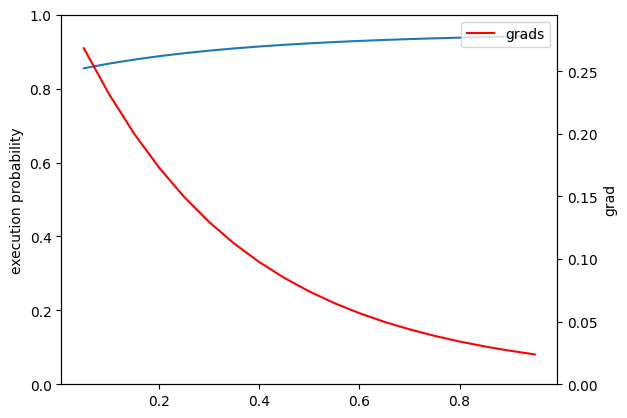

In [18]:
# another test
probas,grads = [],[]
scale = 1
interval = np.arange(0.05*scale,1*scale,0.05*scale)
for t in interval:
    t = torch.tensor([t],dtype=torch.float)
    proba,grad = decoder(phi,t,True)
    probas.append(float(proba))
    grads.append(float(grad))

plt.plot(interval,probas,label="probas")
plt.ylabel("execution probability")
plt.ylim(0,1)
twin = plt.gca().twinx()
twin.plot(interval,grads,c='r',label="grads")
twin.set_ylabel("grad")
twin.set_ylim(0,1.1*max(grads))
plt.legend()

In [19]:
class MyLittleEncoderDecoder(nn.Module):

    def __init__(self, n_time_series,len_in):
        super().__init__()
        self.encoder = MyLittleEncoder(n_time_series,len_in)
        self.decoder = MyLittleDecoder(4) # n_heads*embed_dim
        
    
    def forward(self, x, t, grad=False):
        phi = self.encoder(x)
        # print("phi: ",phi)
        if grad:
            exec_proba,hazard_rate = self.decoder(phi,t,True)
            return exec_proba,hazard_rate
        exec_proba = self.decoder(phi,t)
        return exec_proba
    
    def train(self,dataset, batch_size):
        # set up
        loss_list = []
        optimizer = torch.optim.Adam(self.parameters())
        numerical_grad_eps = 1e-3

        # train, manual batch
        for idx_batch in range(len(dataset)//batch_size):
            # set up
            optimizer.zero_grad()
            mean_loss = 0

            # batch
            for idx in range(batch_size):
                X,t,cause = dataset[idx_batch*batch_size+idx]
                # print("t: ",t)
                exec_proba,hazard_rate = self.forward(X,t,True)
                # print("exec_proba: ",exec_proba)
                assert not torch.any(torch.isnan(exec_proba))
                # hazard_rate = (self.forward(X,t+numerical_grad_eps)-exec_proba)/numerical_grad_eps
                assert exec_proba < 1.
                rcll = (cause*torch.log(hazard_rate+1e-9)+(1-cause)*torch.log(1-exec_proba))
                loss = -rcll/batch_size
                # print("loss: ",batch_size*loss)
                loss.backward()
                mean_loss += float(loss)

            # done
            # for param in self.parameters():
            #     print(param.shape)
            #     print(param.grad)
            optimizer.step()
            loss_list.append(mean_loss)
            print("mean batch loss: ",float(mean_loss))
            if math.isnan(mean_loss):
                    break
            
        return loss_list

In [20]:
# test
my_little_model = MyLittleEncoderDecoder(28,100)
proba = my_little_model(X,lifetime)

proba,grad = my_little_model(X,lifetime,True)
print(proba,grad)

tensor(0.9440, grad_fn=<SqueezeBackward1>) tensor(0.0010)


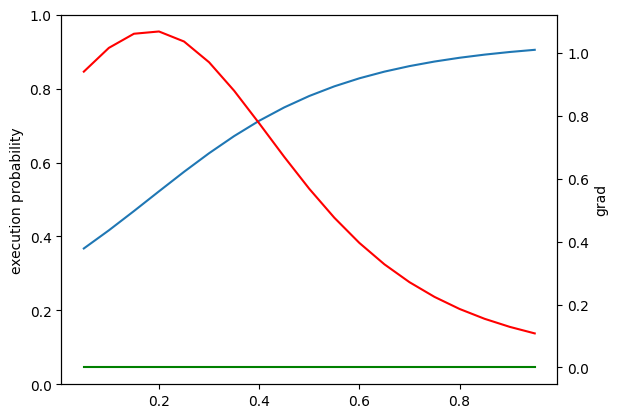

In [21]:
# another test
probas,grads,numerical_grads = [],[],[]
scale = 1
numerical_grad_eps = 1e-9

interval = np.arange(0.05*scale,1*scale,0.05*scale)
for t in interval:
    t = torch.tensor([t],dtype=torch.float)
    proba,grad = my_little_model(X,t,True)
    num_grad = (my_little_model(X,t+numerical_grad_eps)-proba)/numerical_grad_eps
    probas.append(float(proba))
    grads.append(float(grad))
    numerical_grads.append(float(num_grad))

plt.plot(interval,probas)
plt.ylabel("execution probability")
plt.ylim(0,1)
twin = plt.gca().twinx()
twin.plot(interval,grads,c='r')
twin.set_ylabel("grad")
twin.plot(interval,numerical_grads,c='g')

## Training

In [22]:
from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __init__(self, datapoints):
        self.datapoints = [(torch.tensor(X,dtype=torch.float),torch.tensor([t],dtype=torch.float),torch.tensor(cause,dtype=torch.float)) for X,t,cause in datapoints]
        
    def __len__(self):
        return len(self.datapoints)
    
    def __getitem__(self, idx):
        idx = np.random.randint(len(self.datapoints))
        return self.datapoints[idx]
    
# Create the dataset    
_dataset = [elem for elem in datapoints[0]] # if elem[2]==0
dataset = MyDataset(_dataset) # level 0

Tests ?
- Loss seems ok, monitor the gradient
- test without right censored elements
- monitor the gradient flow

In [23]:
# model parameters
my_little_model.parameters

<bound method Module.parameters of MyLittleEncoderDecoder(
  (encoder): MyLittleEncoder(
    (convolutions): ModuleList(
      (0-3): 4 x Conv1d(28, 3, kernel_size=(3,), stride=(4,), dilation=(3,))
    )
    (attention_head): ScaledDotProductAttention()
    (serie_to_state): Conv1d(4, 4, kernel_size=(24,), stride=(1,))
  )
  (decoder): MyLittleDecoder(
    (fc): Linear(in_features=4, out_features=8, bias=False)
    (log_weights): ParameterList(
        (0): Parameter containing: [torch.float32 of size 8x1]
        (1): Parameter containing: [torch.float32 of size 8x8]
        (2): Parameter containing: [torch.float32 of size 1x8]
    )
  )
)>

In [24]:
# train
loss_list = []
num_epochs = 100
for epoch in range(num_epochs):
    loss_list += my_little_model.train(dataset, 16)
plt.semilogy(loss_list)
plt.title("loss")
plt.show()

mean batch loss:  1.0142129547894
mean batch loss:  0.30700271110981703
mean batch loss:  0.7021938236430287
mean batch loss:  0.45749571174383163
mean batch loss:  0.2633125055581331
mean batch loss:  0.2529187388718128
mean batch loss:  0.33734283223748207
mean batch loss:  0.6242396691814065
mean batch loss:  0.8958668019622564
mean batch loss:  0.6153121832758188
mean batch loss:  1.3072362607344985
mean batch loss:  0.40405273996293545
mean batch loss:  0.35343158803880215
mean batch loss:  0.517976432107389
mean batch loss:  0.579218540340662
mean batch loss:  0.49441615771502256
mean batch loss:  0.46799951419234276
mean batch loss:  0.6195534011349082
mean batch loss:  0.29503883328288794
mean batch loss:  0.6418613493442535
mean batch loss:  0.49671722669154406
mean batch loss:  0.43108969181776047
mean batch loss:  0.2736891992390156
mean batch loss:  0.51066436432302
mean batch loss:  0.5664770742878318
mean batch loss:  0.8568633897230029
mean batch loss:  0.526026882231235

AssertionError: 

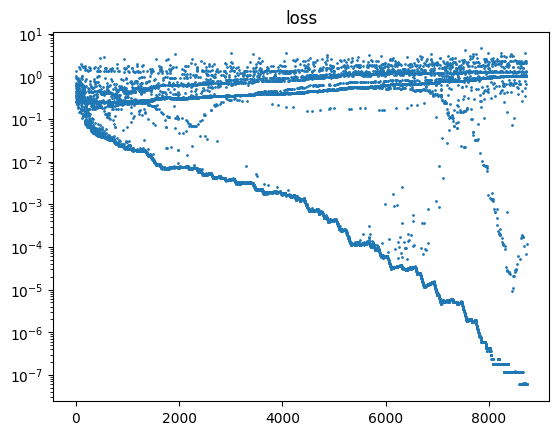

In [29]:
plt.scatter(range(len(loss_list)),loss_list,s=1)
plt.title("loss")
plt.gca().set_yscale('log')
plt.show()